In [3]:
!pip install transformers datasets

     |████████████████████████████████| 153 kB 1.5 MB/s eta 0:00:01
     |████████████████████████████████| 1.4 MB 2.3 MB/s eta 0:00:01
     |████████████████████████████████| 81 kB 4.3 MB/s eta 0:00:01
     |████████████████████████████████| 126 kB 4.4 MB/s eta 0:00:01
     |████████████████████████████████| 17.8 MB 6.2 MB/s eta 0:00:01
     |████████████████████████████████| 738 kB 8.5 MB/s eta 0:00:01
     |████████████████████████████████| 883 kB 8.4 MB/s eta 0:00:01
     |████████████████████████████████| 2.9 MB 7.4 MB/s eta 0:00:01
     |████████████████████████████████| 243 kB 6.9 MB/s eta 0:00:01
  Created wheel for sacremoses: filename=sacremoses-0.0.43-py3-none-any.whl size=893259 sha256=498080113d1f8c140c74c78546554bb3ce019819e229033609a15dfe695caa60
  Stored in directory: /home/user/.cache/pip/wheels/7b/78/f4/27d43a65043e1b75dbddaa421b573eddc67e712be4b1c80677
Successfully built sacremoses


In [2]:
# !conda install matplotlib

In [3]:
# !pip install torch-lr-finder

In [4]:
# !pip install nonechucks

In [4]:
from argparse import ArgumentParser
from datetime import datetime
from typing import Optional
import numpy as np
import pytorch_lightning as pl
import torch
from torch import nn
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader
from torch.utils.data.sampler import Sampler
import torch.nn.functional as F
from transformers import (
    AdamW,
    AutoModel,
    AutoModelForSequenceClassification,
    AutoConfig,
    AutoTokenizer,
    get_linear_schedule_with_warmup,
    glue_compute_metrics,
    PhobertTokenizer
)
import datasets
import pandas as pd
from textprocessor.normalization import VncorenlpTokenizer

from gensim.models import KeyedVectors

from readers.DrQA import data, model, module as reader_module
from readers.DrQA import config as cfg

from pytorch_lightning.loggers import TensorBoardLogger
# import nonechucks as nc

# Prepare Data

In [5]:
class SimpleDataset(torch.utils.data.Dataset):
    def __init__(self, vocab, pos_vocab, ner_vocab, max_seq_length, encodings, aug=None):
        self.encodings = encodings
        self.aug = aug
        self.len_enc = len(self.encodings['labels'])
        self.vocab = vocab
        self.ner_vocab =  ner_vocab
        self.pos_vocab = pos_vocab
        self.max_seq_length = max_seq_length
        if aug is not None:
            self.len_aug = len(self.aug['labels'])
            print('len aug', self.len_aug)
    
    def _single_toksnfeat2ids(self, text_toks:str, pos_toks:str, ner_toks:str):
        try:
            text_toks = text_toks.strip().lower().split(' ')
            pos_toks = pos_toks.strip().lower().split(' ')
            ner_toks = ner_toks.strip().lower().split(' ')
        except Exception:
            print('..........')
            print(text_toks, pos_toks, ner_toks)
        tok_ids = []
        pos_ids = []
        ner_ids = []
        for i in range(len(text_toks)):
            if i >= self.max_seq_length:
                break
            try:
                tok_ids.append(self.vocab[text_toks[i]])
                pos_ids.append(self.pos_vocab[pos_toks[i]])
                ner_ids.append(self.ner_vocab[ner_toks[i]])
            except:
                print('sda..........')
                
                print(text_toks, pos_toks, ner_toks)

        return tok_ids, pos_ids, ner_ids
    
    def idsitem(self, item):
        x1, pos1, ner1 = self._single_toksnfeat2ids(item['x1'], item['x1_f'][0], item['x1_f'][1])
        x2, pos2, ner2 = self._single_toksnfeat2ids(item['x2'], item['x2_f'][0], item['x2_f'][1])
        iitem = {'x1': x1, 'x2': x2, 'x1_f': [pos1, ner1], 'x2_f': [pos2, ner2]}        
        return iitem
    
    def _get_non_aug(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items() if key != 'labels'}
        item = self.idsitem(item)
        item['labels'] = int(self.encodings['labels'][idx])
        return item
    
    def _get_aug(self, idx):
        try:
            item = {key: val[idx] for key, val in self.aug.items() if key != 'labels'}
            item = self.idsitem(item)
            item['labels'] = int(self.aug['labels'][idx])
        except:
            idx = 0
            item = {key: val[idx] for key, val in self.aug.items() if key != 'labels'}
            item = self.idsitem(item)
            item['labels'] = int(self.aug['labels'][idx])
        return item

    def __getitem__(self, idx):
        if self.aug is not None and torch.rand((1, )) < 0.2:
            return self._get_aug(idx % self.len_aug)
        else:
            return self._get_non_aug(idx % self.len_enc)
        return item

    def __len__(self):
        if self.aug is None:
            return self.len_enc
        else:
            return self.len_enc + self.len_aug
            
    def lengths(self):
        ret = [(len(ex[0]), len(ex[1]))
                for ex in zip(self.encodings['x1'], self.encodings['x2'])]
        rm = []
        if self.aug is not None:
            for ex in zip(self.encodings['x1'], self.encodings['x2']):
                try:
                    ret.append((len(ex[0]), len(ex[1])))
                except:
                    continue
        return ret

In [6]:

def _pad(l, val, max_len):
    l += [val]*(max_len - len(l))
    return l
def _pad_group(g):
    max_len = max([len(x) for x in g[0]])
    mask = []
    for i in range(len(g[0])):
        mask.append([0]*len(g[0][i]) + [1]*(max_len - len(g[0][i])))
        _pad(g[0][i], 1, max_len)
        _pad(g[1][i][0], 1, max_len)
        _pad(g[1][i][1], 1, max_len)
#         print(g)
    return mask
def pad(batch):
#     print(batch)
    features = ['x1','x1_f', 'x2', 'x2_f', 'labels']
    d = {f:[] for f in features}
    for i in batch:
        for f in features:
            d[f].append(i[f])
    q = [d['x1'], d['x1_f']]
    p = [d['x2'], d['x2_f']]
    d['x1_mask'] = _pad_group(q)
    d['x2_mask'] = _pad_group(p)
    for k, v in d.items():
        try:
            d[k] = torch.tensor(v)
        except Exception:
            print(v)
    return d

In [7]:
class SortedBatchSampler(Sampler):

    def __init__(self, lengths, batch_size, shuffle=True):
        self.lengths = lengths
        self.batch_size = batch_size
        self.shuffle = shuffle

    def __iter__(self):
        lengths = np.array([(-l[0], -l[1], np.random.random()) for l in self.lengths],dtype=[('l1', np.int_), ('l2', np.int_), ('rand', np.float_)])
        indices = np.argsort(lengths, order=('l1', 'l2', 'rand'))
        batches = [indices[i:i + self.batch_size]
                   for i in range(0, len(indices), self.batch_size)]
        if self.shuffle:
            np.random.shuffle(batches)
        return iter([i for batch in batches for i in batch])

    def __len__(self):
        return len(self.lengths)


class GensimDataModule(pl.LightningDataModule):
    tok_field = 'toks'
    pos_field = 'pos'
    ner_field = 'ner'
    
    q_pref = 'q_'
    t_pref = 't_'
    num_labels = 2

    def __init__(
        self,
        vocab,
        pos_vocab,
        ner_vocab,
        max_seq_length: int = 128,
        train_batch_size: int = 32,
        eval_batch_size: int = 32,
        **kwargs
    ):
        super().__init__()
        self.vocab = vocab
        self.pos_vocab = pos_vocab
        self.ner_vocab = ner_vocab
        self.max_seq_length = max_seq_length
        self.train_batch_size = train_batch_size
        self.eval_batch_size = eval_batch_size

    def filtnan(self, df):
        tmp = df.replace(np.nan, '', regex=True)
        return tmp[(tmp['t_toks'] != '') & (tmp['q_toks'] != '')]
    
    def setup(self, stage, df_ls):
        
        train_df = df_ls[0]
        
        valid_df = df_ls[1]
        if len(df_ls) == 3:
            aug_df = df_ls[2]
            self.dataset = {
                "train": SimpleDataset(self.vocab, self.pos_vocab, self.ner_vocab, self.max_seq_length, self.convert_to_features(train_df), self.convert_to_features(aug_df)),
                "validation": SimpleDataset(self.vocab, self.pos_vocab, self.ner_vocab, self.max_seq_length, self.convert_to_features(valid_df)),
                }
        else:
            self.dataset = {
                "train": SimpleDataset(self.vocab, self.pos_vocab, self.ner_vocab, self.max_seq_length, self.convert_to_features(train_df)),
                "validation": SimpleDataset(self.vocab, self.pos_vocab, self.ner_vocab, self.max_seq_length, self.convert_to_features(valid_df)),
                }
        self.eval_splits = ["validation"]
    def prepare_data(self):
        pass
    def train_dataloader(self):
        sampler = SortedBatchSampler(
            self.dataset['train'].lengths(),
            self.train_batch_size,
            shuffle=False
        )
        return DataLoader(self.dataset['train'], batch_size=self.train_batch_size, collate_fn=pad, sampler=sampler, num_workers=4, pin_memory=True)
    def val_dataloader(self):
        sampler = SortedBatchSampler(
            self.dataset['validation'].lengths(),
            self.eval_batch_size,
            shuffle=False
        )
        return DataLoader(self.dataset['validation'], batch_size=self.eval_batch_size, collate_fn=pad, sampler=sampler, num_workers=4, pin_memory=True)

    def test_dataloader(self):
        return DataLoader(self.dataset['validation'], batch_size=self.eval_batch_size, collate_fn=pad,num_workers=4, pin_memory=True)
    
    def tok2id(self, tokens):
        return tensor([self.vocab[tok.lower()] for tok in tokens], dtype=torch.int64)
    def ids2toks(self, ids):
        return ' '.join([self.vocab[ind] for ind in ids.tolist()])
    
    def _single_toksnfeat2ids(self, text_toks:str, pos_toks:str, ner_toks:str):
        text_toks = text_toks.strip().lower().split(' ')
        pos_toks = pos_toks.strip().lower().split(' ')
        ner_toks = ner_toks.strip().lower().split(' ')
        tok_ids = []
        pos_ids = []
        ner_ids = []
        for i in range(len(text_toks)):
            if i >= self.max_seq_length:
                break
            tok_ids.append(self.vocab[text_toks[i]])
            pos_ids.append(self.pos_vocab[pos_toks[i]])
            ner_ids.append(self.ner_vocab[ner_toks[i]])
        return tok_ids, pos_ids, ner_ids

    
    def toksnfeat2ids(self, tok, pos, ner, padding=True):
        assert len(tok) == len(pos) and len(tok) == len(ner)
        longest = 0
        batch_tok_ids = []
        batch_pos_ids = []
        batch_ner_ids = []
        batch_mask = []
        for i in range(len(tok)):
            try:
                if len(tok[i]) <= 0:
                    continue
                tok_ids, pos_ids, ner_ids = self._single_toksnfeat2ids(tok[i], pos[i], ner[i])
                batch_tok_ids.append(tok_ids)
                batch_pos_ids.append(pos_ids)
                batch_ner_ids.append(ner_ids)
                batch_mask.append([0]*len(tok_ids))
            except TypeError:
#                 print('Skip ', tok[i])
                continue
        return batch_tok_ids, batch_pos_ids, batch_ner_ids, batch_mask
        
    def convert_to_features(self, example_batch, indices=None):
        features = {
            'x1': example_batch[self.q_pref + self.tok_field].tolist(),
            'x1_f': list(zip(example_batch[self.q_pref + self.pos_field], example_batch[self.q_pref + self.ner_field])),
            'x2': example_batch[self.t_pref + self.tok_field].tolist(),
            'x2_f': list(zip(example_batch[self.t_pref + self.pos_field], example_batch[self.t_pref + self.ner_field])),
            'labels': example_batch['label']
        }
        return features

In [8]:
wv_path = 'wordembedding/pretrain_models/word2vec/baomoi.window2.vn.model.bin'
wv = KeyedVectors.load_word2vec_format(wv_path,binary=True)
vocab = data.W2VVocab(['<unk>', '<pad>', '<cls>'], 0, 1, wv)

In [9]:
ner_vocab = data.ReaderVocab.from_file('dataset/vocabs/train_feat_ner_vocab.txt')
ner_vocab.UNK='<unk>'
pos_vocab = data.ReaderVocab.from_file('dataset/vocabs/train_feat_pos_vocab.txt')
pos_vocab.UNK='<unk>'

In [10]:
w_in_train = []
with open('dataset/vocabs/zlqa_token_list.txt', 'r') as f:
    while True:
        line = f.readline()
        if not line:
            break
        w_in_train.append(line.split(' ')[-1][:-1].lower())

In [13]:
dm = GensimDataModule(vocab, pos_vocab, ner_vocab)

In [14]:
# dm.prepare_data()
# dm.setup('fit')

In [15]:
# next(iter(dm.train_dataloader()))

# Training

In [17]:
def parse_args(args=None):
    parser = ArgumentParser()
    parser = pl.Trainer.add_argparse_args(parser)
    parser = GensimDataModule.add_argparse_args(parser)
    parser = DrQA.add_model_specific_args(parser)
    parser.add_argument('--seed', type=int, default=42)
    return parser.parse_args(args)


In [29]:
args = cfg.Args()
# args.max_len = 256
args.hidden_size = 512
args.context_layers = 3
args.question_layers = 2
args.concat_rnn_layers = True
args.dropout_rnn = 0.2
args.dropout_emb = 0.1
args.layernorm_emb = True
args.dropout_rnn_output = True
args.embedding_dim = 300
args.num_features = 2

mocked_args = """
    --max_epochs 20
    --gpus 1
    --learning_rate 2e-3
    --adam_epsilon 1e-8
    --weight_decay 1e-1
    --warmup_steps 200
    --max_seq_length 256
    --train_batch_size 64
    --eval_batch_size 64""".split()

In [30]:
margs = parse_args(mocked_args)
pl.seed_everything(margs.seed)

42

In [ ]:
train_df = pd.read_csv('dataset/qaset/train_feature_set2.csv').sample(frac=1).reset_index(drop=True)
aug_df = pd.read_csv('dataset/qaset/aug_feature_set2.csv').sample(frac=1).reset_index(drop=True)
valid_df = pd.read_csv('dataset/qaset/valid_feature_set2.csv').sample(frac=1).reset_index(drop=True)

In [31]:
dm = GensimDataModule.from_argparse_args(margs,vocab=vocab,pos_vocab=pos_vocab, ner_vocab=ner_vocab)
dm.prepare_data()
dm.setup('fit', [train_df, valid_df, aug_df)])

len aug 1 105492
len aug 105492


In [32]:
model = DrQA(args, vocab, [len(pos_vocab), len(ner_vocab)], **vars(margs))

Loading Embedding
Loaded 24631 embeddings (100.00%)


In [33]:
# next(iter(dm.val_dataloader()))

In [35]:
len(dm.train_dataloader())

453

In [36]:
logger = TensorBoardLogger('tb_logs', name='DrQA01')

In [37]:
# runs 1 train, val, test batch and program ends
# trainer = pl.Trainer.from_argparse_args(margs, fast_dev_run=True, logger=logger)

In [38]:
trainer = pl.Trainer.from_argparse_args(margs, logger=logger, auto_lr_find=True)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/opt/conda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: you defined a validation_step but have no val_dataloader. Skipping validation loop
  warnings.warn(*args, **kwargs)

  | Name              | Type             | Params
-------------------------------------------------------
0 | embedding         | EmbeddingModule  | 131 M 
1 | embedding_feature | ModuleList       | 41    
2 | network           | RnnDocReader     | 33.2 M
3 | loss_fct          | CrossEntropyLoss | 0     


LR finder stopped early due to diverging loss.


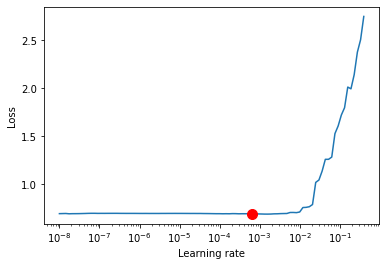

In [39]:
lr_finder = trainer.tuner.lr_find(model, train_dataloader=dm.train_dataloader())
fig = lr_finder.plot(suggest=True)
fig.show()

In [40]:
model.hparams.lr = lr_finder.suggestion()

In [ ]:
trainer.fit(model, dm)


  | Name              | Type             | Params
-------------------------------------------------------
0 | embedding         | EmbeddingModule  | 131 M 
1 | embedding_feature | ModuleList       | 41    
2 | network           | RnnDocReader     | 33.2 M
3 | loss_fct          | CrossEntropyLoss | 0     


/opt/conda/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


In [37]:
len(dm.train_dataloader())

3750

In [31]:
ner_vocab.UNK='<unk>'

In [32]:
ner_vocab['a']

0